# Crime Prediction in Chicago

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns

from scipy.stats.contingency import association
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## Data Loading

Features that were not loaded:-
  - Beacuse they have no meaning
    - ID
    - Case Number
    - Block
    - Year
    - Updated On
  - Because they represent other features:-
    - IUCR
    - FBI Code
    - X Coordinate
    - Y Coordinate
    - Location

In [2]:
df = pd.read_csv('crime_prediction_in_chicago_dataset.csv',
                 usecols=['Date', 'Primary Type', 'Description', 'Location Description',
                          'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
                          'Latitude', 'Longitude'],
                 parse_dates=['Date'])

df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude
0,2022-01-14 15:55:00,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,724,7,16.0,68,41.771782,-87.649437
1,2022-08-05 21:00:00,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,324,3,5.0,69,41.763338,-87.597001
2,2022-08-14 14:00:00,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,1621,16,39.0,11,41.985875,-87.766404
3,2022-11-10 03:47:00,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,733,7,17.0,68,41.762615,-87.652840
4,2022-08-15 09:00:00,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,113,1,4.0,32,NaN,NaN


## Data Pre-processing

Remove:-
  - Duplicate Values
  - Null Values; Only represent 2% of the dataset
  - Outliers

In [3]:
df.drop_duplicates(inplace=True)

df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233859 entries, 0 to 239557
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  233859 non-null  datetime64[ns]
 1   Primary Type          233859 non-null  object        
 2   Description           233859 non-null  object        
 3   Location Description  233859 non-null  object        
 4   Arrest                233859 non-null  bool          
 5   Domestic              233859 non-null  bool          
 6   Beat                  233859 non-null  int64         
 7   District              233859 non-null  int64         
 8   Ward                  233859 non-null  float64       
 9   Community Area        233859 non-null  int64         
 10  Latitude              233859 non-null  float64       
 11  Longitude             233859 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(3), int64(3), object(3)


In [4]:
df.describe()

,Date,Beat,District,Ward,Community Area,Latitude,Longitude
count,233859,233859.000000,233859.000000,233859.000000,233859.000000,233859.000000,233859.000000
mean,2022-07-12 02:26:23.823072768,1151.961870,11.290243,23.312688,36.365100,41.845481,-87.668599
min,2022-01-01 00:00:00,111.000000,1.000000,1.000000,1.000000,36.619446,-91.686566
25%,2022-04-18 22:52:30,533.000000,5.000000,9.000000,22.000000,41.769075,-87.710185
50%,2022-07-17 04:10:00,1032.000000,10.000000,24.000000,32.000000,41.862842,-87.661486
75%,2022-10-06 20:00:00,1724.000000,17.000000,35.000000,53.000000,41.908858,-87.626402
max,2022-12-31 23:55:00,2535.000000,31.000000,50.000000,77.000000,42.022548,-87.524532
std,NaN,707.814111,7.074863,14.189333,21.537201,0.088833,0.061021


In [5]:
df = df.loc[df['District'] <= 25]

df = df.loc[df['Latitude'] >= 41.6]

## Feature Selection

### Correlation

In [6]:
correlation_test_df = df.loc[:, ['Date', 'Arrest', 'Latitude', 'Longitude']]

correlation_test_df['Day'] = correlation_test_df['Date'].dt.day
correlation_test_df['Hour'] = correlation_test_df['Date'].dt.hour
correlation_test_df['Month'] = correlation_test_df['Date'].dt.month
correlation_test_df['Day of Week'] = correlation_test_df['Date'].dt.day_of_week

correlation_test_df.drop('Date', axis=1, inplace=True)

<Axes: title={'center': 'Correlation Heat Map'}>

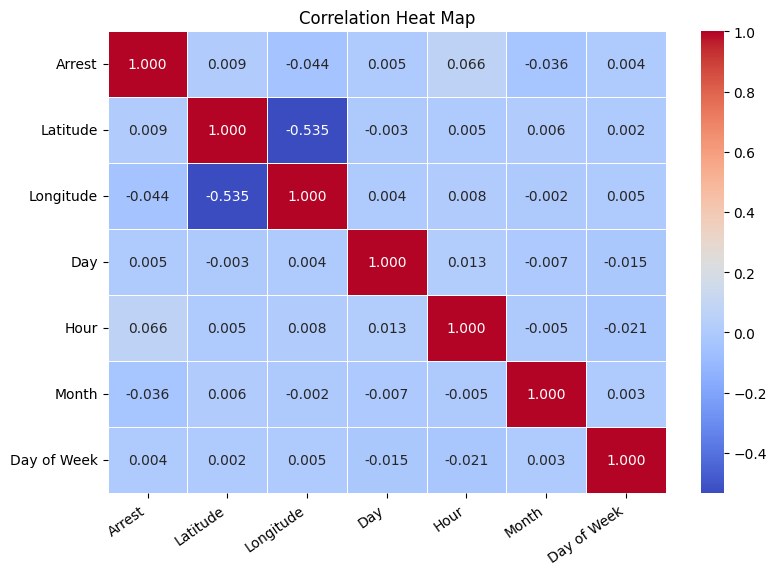

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(data=correlation_test_df.corr(), annot=True, linewidth=0.5, fmt='.3f', cmap='coolwarm')

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Correlation Heat Map')

ax

### Association

In [8]:
association_test_df = df.drop(['Date', 'Latitude', 'Longitude'], axis=1)

association_test_list = []

for i in range(association_test_df.columns.size):
  association_test_list.append([])

  for j in range(association_test_df.columns.size):
    association_test_list[i].append(
      association(pd.crosstab(association_test_df.iloc[:, i], association_test_df.iloc[:, j]), method='cramer')
    )

<Axes: title={'center': 'Association Heat Map'}>

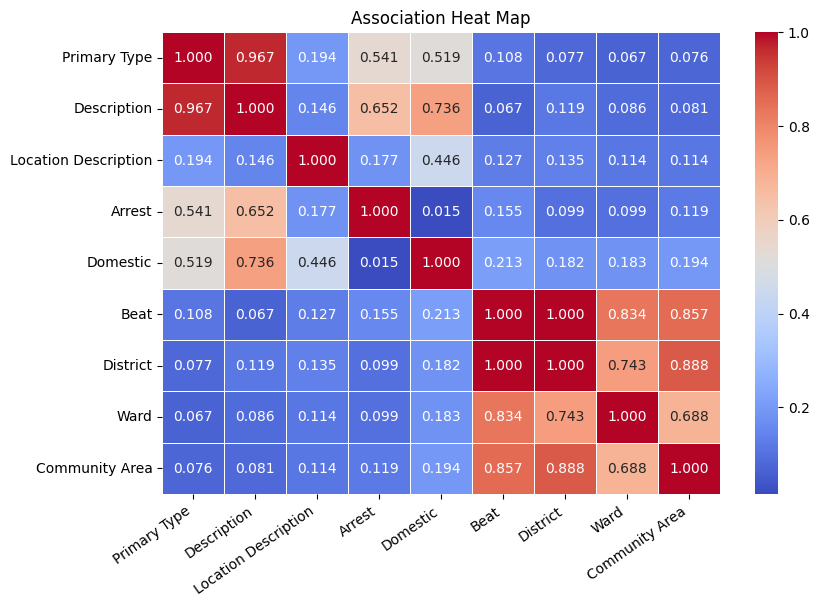

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(data=association_test_list, annot=True, linewidth=0.5, fmt='.3f',
                 xticklabels=['Primary Type', 'Description', 'Location Description', 'Arrest',
                              'Domestic', 'Beat', 'District', 'Ward', 'Community Area'],
                 yticklabels=['Primary Type', 'Description', 'Location Description', 'Arrest',
                              'Domestic', 'Beat', 'District', 'Ward', 'Community Area'],
                 cmap='coolwarm')

ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_title('Association Heat Map')

ax

### Conclusion

Selected Features:-
  - Primary Type
  - Location Description
  - Community Area

**Note:-**
  - Beat was not selected because it has 3000 unique values and some of them are not in the dataset.
  - Description was not select because it has high association with Primary Type but has more unique values.

In [10]:
df.drop(['Date', 'Description', 'Domestic', 'Beat', 'District', 'Ward', 'Latitude', 'Longitude'], axis=1, inplace=True)

## Model Training & Evaluation

In [11]:
df['Community Area'] = df['Community Area'].astype(str)

label = df['Arrest']
features = df.drop('Arrest', axis=1)

encoder = OneHotEncoder(sparse_output=False).fit(features)

features = pd.DataFrame(encoder.transform(features), columns=encoder.get_feature_names_out())

In [12]:
with open('./saved_models/encoder.pkl', 'wb') as file:
  pkl.dump(encoder, file)

In [13]:
train_features, test_features, train_label, test_label = train_test_split(features, label, test_size=0.2, random_state=42)

In [14]:
def print_report(model, test_features, test_label):
  print('Classification Report:-')
  print(classification_report(test_label, model.predict(test_features), target_names=['Not Arrested', 'Arrested']))

  ConfusionMatrixDisplay.from_estimator(model, test_features, test_label,
                                        display_labels=['Not Arrested', 'Arrested']).ax_.set_title('Confusion Matrix')
  
  RocCurveDisplay.from_estimator(model, test_features, test_label).ax_.set_title('ROC curve')

### Logistic Regression

In [15]:
logistic_regression = LogisticRegression(solver='sag', class_weight='balanced', max_iter=10000).fit(train_features, train_label)

In [16]:
with open('./saved_models/logistic_regression.pkl', 'wb') as file:
  pkl.dump(logistic_regression, file)

Classification Report:-
              precision    recall  f1-score   support

Not Arrested       0.96      0.77      0.85     41302
    Arrested       0.30      0.74      0.43      5467

    accuracy                           0.77     46769
   macro avg       0.63      0.75      0.64     46769
weighted avg       0.88      0.77      0.80     46769



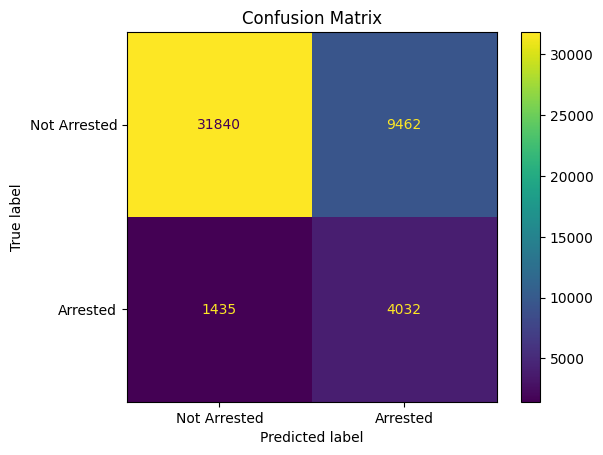

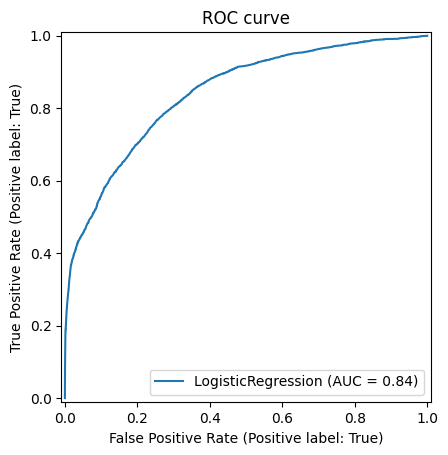

In [17]:
print_report(logistic_regression, test_features, test_label)

### K-Nearest Neighbors

K value selection was done using the **Cross Validation**:-

![Cross Validation Score of K values between 10 & 30](clv_of_knn.png)

In [18]:
k_neighbors_classifier = KNeighborsClassifier(n_neighbors=19, weights='distance').fit(train_features, train_label)

In [19]:
with open('./saved_models/k_neighbors_classifier.pkl', 'wb') as file:
  pkl.dump(k_neighbors_classifier, file)

Classification Report:-
              precision    recall  f1-score   support

Not Arrested       0.92      0.98      0.95     41302
    Arrested       0.73      0.37      0.49      5467

    accuracy                           0.91     46769
   macro avg       0.82      0.68      0.72     46769
weighted avg       0.90      0.91      0.90     46769



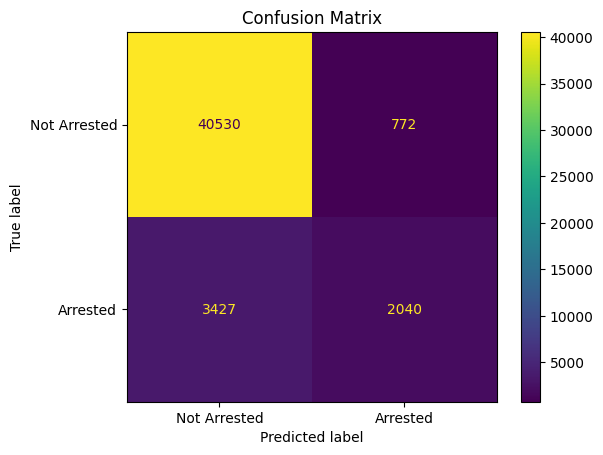

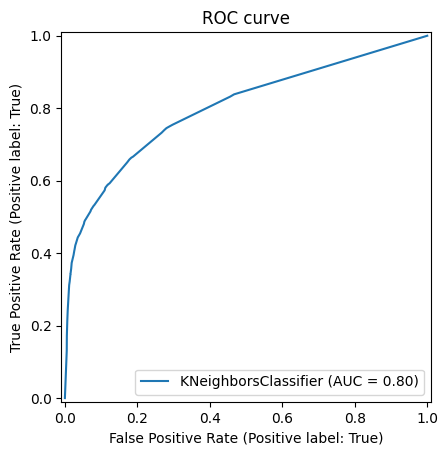

In [20]:
print_report(k_neighbors_classifier, test_features, test_label)

### Decision Tree

In [21]:
decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', class_weight='balanced').fit(train_features, train_label)

In [22]:
with open('./saved_models/decision_tree_classifier.pkl', 'wb') as file:
  pkl.dump(decision_tree_classifier, file)

Classification Report:-
              precision    recall  f1-score   support

Not Arrested       0.96      0.78      0.86     41302
    Arrested       0.30      0.72      0.43      5467

    accuracy                           0.77     46769
   macro avg       0.63      0.75      0.64     46769
weighted avg       0.88      0.77      0.81     46769



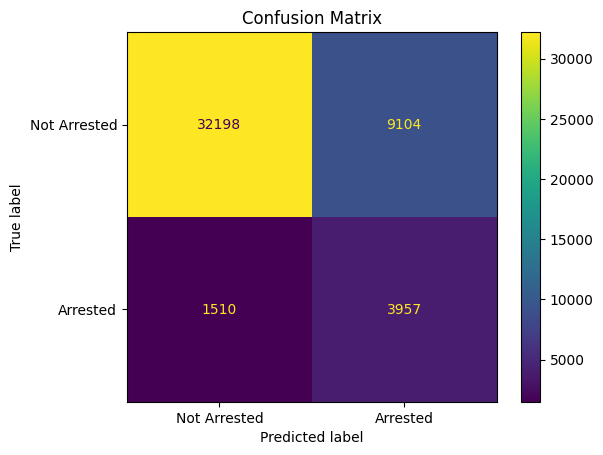

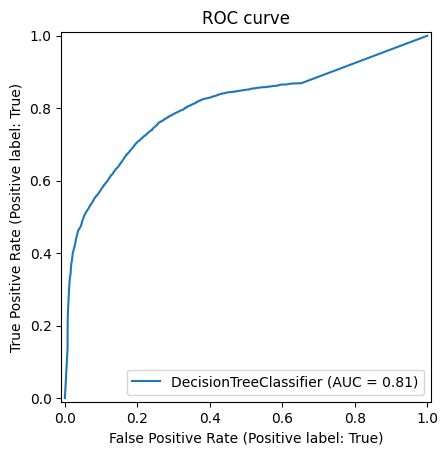

In [23]:
print_report(decision_tree_classifier, test_features, test_label)

### Support Vector Machine

LinearSVC was used because it handles large datasets better

In [24]:
svm_classifier = LinearSVC(class_weight='balanced').fit(train_features, train_label)

In [25]:
with open('./saved_models/svm_classifier.pkl', 'wb') as file:
  pkl.dump(svm_classifier, file)

Classification Report:-
              precision    recall  f1-score   support

Not Arrested       0.96      0.75      0.84     41302
    Arrested       0.29      0.76      0.42      5467

    accuracy                           0.76     46769
   macro avg       0.62      0.76      0.63     46769
weighted avg       0.88      0.76      0.80     46769



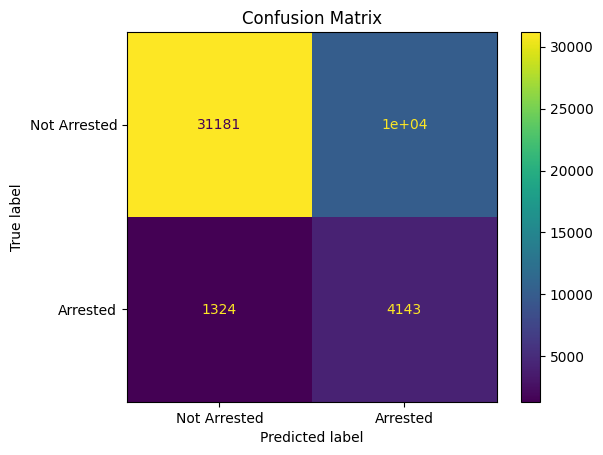

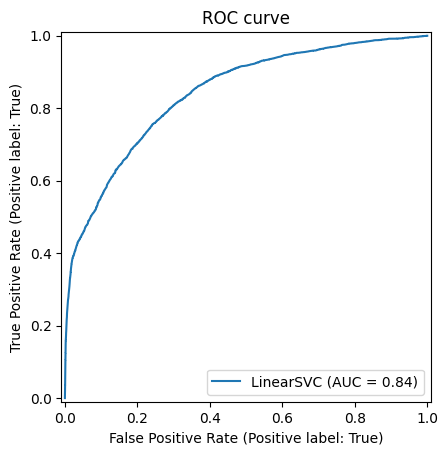

In [26]:
print_report(svm_classifier, test_features, test_label)